In [120]:
#%% Import Moduels

## System Tools
from _Public import *

import seaborn as sns
import matplotlib.backends.backend_pdf as figpdf
import matplotlib.dates as matdates
import pyfixest as pf
from binsreg import *

## Output Folder
OutputFolder = 'Micro_data/results/Analysis_EventStudy/'
if not os.path.exists(OutputFolder):
    os.makedirs(OutputFolder)
## Self-written Modules
import Toolkit_TimeSeries as MyTS
import Toolkit_Graphics as MyGR

# Prepare the data

## Load in the data

In [121]:
# Sample used for the analysis
PriceChange = pd.read_pickle('Micro_data/results/Analysis_PriceChange/PriceChange_Sample.p')

In [122]:
# Returns 
DataFolder          =   "Micro_data\\datasets\\SDC\\"
# SDC_AbRetPanel      =   pd.read_pickle(DataFolder+"SDC_AbRet_Panel.p")
SDC_RetPanel = pd.read_pickle(DataFolder+"SDC_Ret.p")

In [123]:
SDC_RetPanel.columns 

Index(['IssueID', 'FilingDate', 'LaunchDate', 'IssueDate', 'Date', 'Ret_NAdj',
       'Ret_Adj', 'DiffLogPrice', 'FDate_NAdj', 'FDate_Adj', 'LDate_NAdj',
       'LDate_Adj', 'IDate_NAdj', 'IDate_Adj', 'SpRet_NAdj', 'SpRet_Adj',
       'DiffLogSpIdx', 'rf_3m', 'mktrf', 'smb', 'hml', 'rmw', 'cma', 'rf',
       'umd', 'ExDiffLogPrice', 'ExDiffLogSpIdx', 'ExRet_NAdj', 'ExRet_Adj',
       'ExSpRet_NAdj', 'ExSpRet_Adj'],
      dtype='object')

In [124]:
SDC_RetPanel = SDC_RetPanel.loc[(SDC_RetPanel['FDate_Adj']>=-100) & (SDC_RetPanel['IDate_Adj']<=50), :]

## Clean the sample

### Daily return (original)

In [125]:
PriceChange.loc[pd.isnull(PriceChange['ShelfIssueFlag']), 'ShelfIssueFlag'] = 1

In [126]:
TempVarDict = {'DiffLogPrice': 'Ret', 'FDate_Adj': 'FDate', 'LDate_Adj': 'LDate', 'IDate_Adj': 'IDate'}
VarList_PC = ['IssueID', 'ShelfIssueFlag']
DS = PriceChange.loc[PriceChange['SampleFlag']==1, VarList_PC] \
     .merge(SDC_RetPanel.loc[:, ['IssueID', 'Date']+list(TempVarDict.keys())].rename(columns=TempVarDict), \
            on='IssueID', how='left')


In [127]:
DS.sort_values(['IssueID', 'Date'], inplace=True)

In [128]:
DS['EventDate'] = DS['FDate']
DS['EventDate'] = DS['EventDate'].where(DS['ShelfIssueFlag'] == 0, DS['LDate'])

In [129]:
DS['AccRet'] = DS.groupby('IssueID')['Ret'].cumsum()

In [130]:
temp = DS.groupby('IssueID').apply(lambda x: x.loc[x['EventDate']<=-1, 'AccRet'].tail(1), include_groups=False).rename('AccRet_0')

In [131]:
DS = DS.merge(temp.reset_index(), on='IssueID', how='left')


In [132]:
DS['AccRet'] = DS['AccRet'] - DS['AccRet_0']

# Distribution of gaps between different events

In [133]:
def CDFPlot(data, LineDict, \
            XLable=r'Number of Business days ($t$)', \
            YLabel=r'Prob[$\Delta t\leq t$]',
            Flag_NoLegend=False):
    Fig = MyGR.Setup_Fig()
    ax = Fig.add_subplot(1,1,1)
    for key, value in LineDict.items():
        MyGR.Line(Color=value['color'], Style=value['style'], Width=1.5).Plot(data.index, data[key]*value['scale'], ax=ax, Label=value['label'])
    
    ax.set_xlim([data.index[0], data.index[-1]])
    ax.set_ylim([0, 1])
    ax.set_ylabel(YLabel, fontsize=8) 
    ax.set_xlabel(XLable, fontsize=8)
    ax.tick_params(axis='both', labelsize=5)
    MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10, Benchmark_X=0)
    if Flag_NoLegend == False:
        plt.legend(loc='best', fontsize=6)
    plt.tight_layout()

    return Fig, ax

In [134]:
DefaultCutoff = sorted(list(range(-5, 0, 1)) + list(range(0, 10, 1)) + list(range(10, 110, 10)) + [-np.inf, np.inf])
def KeyGapDayDistStat(df, CriticalValues=DefaultCutoff):
    temp = df.describe(percentiles=[0.1, 0.25, 0.5, 0.75, 0.9])
    freq = pd.cut(df, bins=CriticalValues, right=False).value_counts(normalize=True).sort_index()
    return pd.concat([temp, freq], axis=0)

In [135]:
TempList = [xx+yy for xx in ['GapBusDays_',] for yy in ['F2L', 'L2I', 'F2I']]
Cutoff = sorted([0, 1, 5, 10, 30, 60, 180, 300] + [-np.inf, np.inf])
TempInd = PriceChange['SampleFlag']==1


In [139]:
GapDayFreqTab = pd.concat([pd.concat([KeyGapDayDistStat(PriceChange.loc[TempInd & (PriceChange['ShelfIssueFlag']==0), vv], CriticalValues=Cutoff) \
                           for vv in TempList], axis=1, join='outer', keys=TempList), \
                           pd.concat([KeyGapDayDistStat(PriceChange.loc[TempInd & (PriceChange['ShelfIssueFlag']==1), vv], CriticalValues=Cutoff) \
                           for vv in TempList], axis=1, join='outer', keys=TempList)], axis=1, join='outer', \
                          keys=['Non-shelf-registered', 'Shelf-registered'])

In [140]:
GapDayFreqTab.to_excel(OutputFolder+'/GapDayFreqTab.xlsx')

In [153]:
GapDayFreqTab.loc[:, idx[:, ['GapBusDays_F2L', 'GapBusDays_L2I']]].to_latex(OutputFolder+'/GapDays_DistStatTab.tex', float_format="%.3g", escape=False)

In [142]:
GapDayFreqTab_Detailed = pd.concat([PriceChange.loc[TempInd, :].groupby('ShelfIssueFlag')[vv].value_counts(normalize=True) \
                                    for vv in TempList], join='outer', axis=1, keys=TempList).fillna(0) \
                           .unstack(level='ShelfIssueFlag').swaplevel(axis=1).fillna(0).sort_index().sort_index(axis=1)

In [143]:
LineDict = \
    {(0, 'GapBusDays_F2I'): {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Non-shelf-registered", 'scale': 1}, \
     (1, 'GapBusDays_F2I'): {'style': 'dashed', 'color': MyGR.MyColor('Black'), 'label': "Shelf-registered", 'scale': 1},  \
     (0, 'GapBusDays_L2I'): {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Non-shelf-registered", 'scale': 1}, \
     (1, 'GapBusDays_L2I'): {'style': 'dashed', 'color': MyGR.MyColor('Black'), 'label': "Shelf-registered", 'scale': 1},  \
     (0, 'GapBusDays_F2L'): {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Non-shelf-registered", 'scale': 1}, \
     (1, 'GapBusDays_F2L'): {'style': 'dashed', 'color': MyGR.MyColor('Black'), 'label': "Shelf-registered", 'scale': 1} \
    }

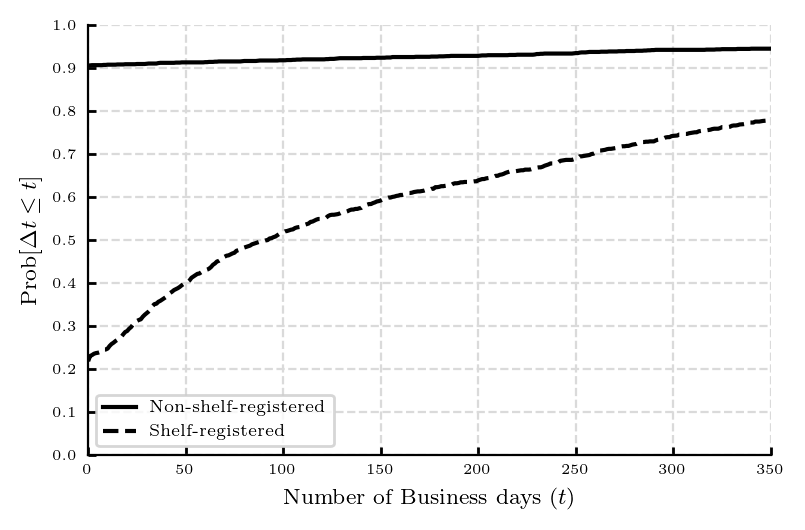

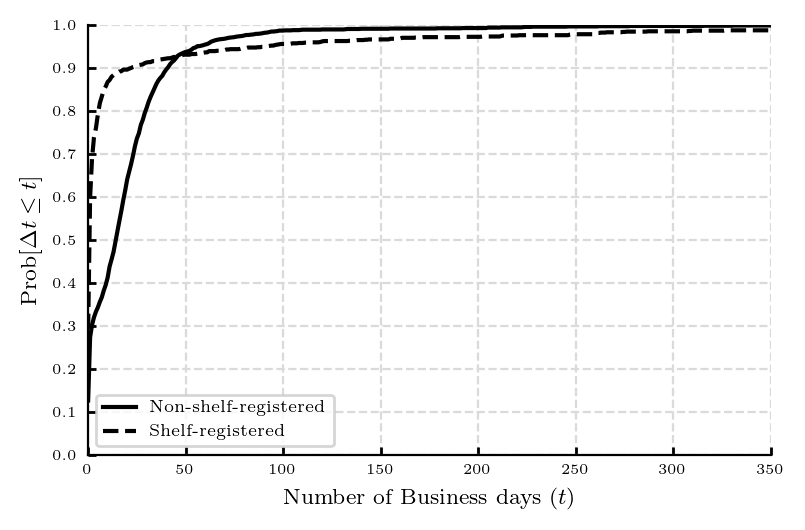

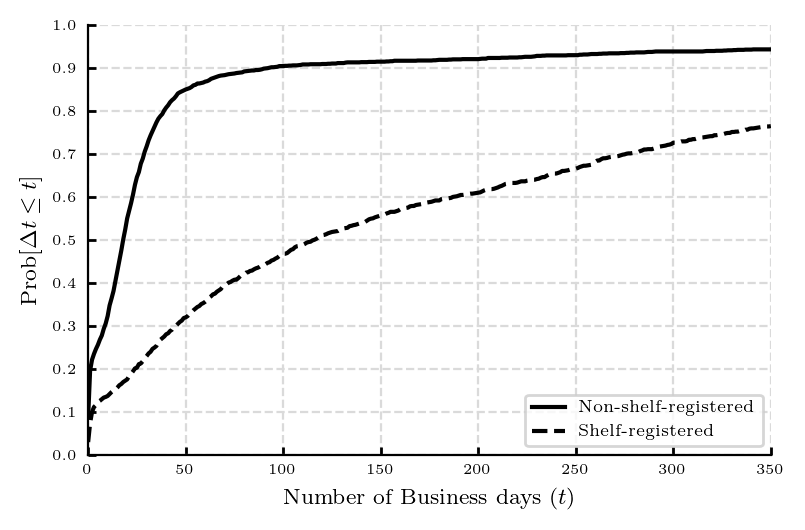

In [144]:

Fig, _ = CDFPlot(GapDayFreqTab_Detailed.loc[0:350, :].cumsum(), {vv: LineDict[vv] for vv in [(0, 'GapBusDays_F2L'), (1, 'GapBusDays_F2L')]})
Fig.savefig(OutputFolder+'/GapDayCDF_F2L.eps', format='eps', dpi=1000)

Fig, _ = CDFPlot(GapDayFreqTab_Detailed.loc[0:350, :].cumsum(), {vv: LineDict[vv] for vv in [(0, 'GapBusDays_L2I'), (1, 'GapBusDays_L2I')]})
Fig.savefig(OutputFolder+'/GapDayCDF_L2I.eps', format='eps', dpi=1000)

Fig, _ = CDFPlot(GapDayFreqTab_Detailed.loc[0:350, :].cumsum(), {vv: LineDict[vv] for vv in [(0, 'GapBusDays_F2I'), (1, 'GapBusDays_F2I')]})
Fig.savefig(OutputFolder+'/GapDayCDF_F2I.eps', format='eps', dpi=1000)

# Event study plot

In [145]:
def KeyRetStat(df):
    Num_Total = df.count()
    # Fraction of zero, positive, and negative values 
    Frac_0 = (df==0).sum()/Num_Total
    Frac_Pos = (df>0).sum()/Num_Total
    Frac_Neg = (df<0).sum()/Num_Total
    FracStat = pd.Series([Frac_0, Frac_Pos, Frac_Neg], index=['Frac_0', 'Frac_Pos', 'Frac_Neg'])
    # Mean, median, and standard deviation
    DescStat = df.describe(percentiles=[0.01, 0.1, 0.25, 0.5, 0.75, 0.9, 0.99])
    Std_Trunc = df.loc[(df<DescStat['99%']) & (df>DescStat['1%'])].std()
    DescStat.loc['std_trunc'] = Std_Trunc
    
    return pd.concat([FracStat, DescStat], axis=0)

In [146]:
# Kep percentile for the daily return 
def EventPlot_Lines(data, LineDict, \
                    XLable=r'Business days relative to the event date', \
                    YLabel=r'Percent',
                    Y_Benchmark=None, Flag_NoLegend=False):
    Fig = MyGR.Setup_Fig()
    ax = Fig.add_subplot(1,1,1)
    for key, value in LineDict.items():
        MyGR.Line(Color=value['color'], Style=value['style'], Width=1.5).Plot(data.index, data[key]*value['scale'], ax=ax, Label=value['label'])
    if Y_Benchmark is not None:
        plt.axhline(y=Y_Benchmark, color=MyGR.MyColor('Black', 0.5), linestyle='solid', linewidth=1, alpha=0.5)
    ax.set_xlim([data.index[0], data.index[-1]])
    ax.set_ylabel(YLabel, fontsize=8) 
    ax.set_xlabel(XLable, fontsize=8)
    ax.tick_params(axis='both', labelsize=5)
    MyGR.Setup_Ax(ax, XTickNbins=10, YTickNbins=10, Benchmark_X=0)
    if Flag_NoLegend == False:
        plt.legend(loc='best', fontsize=6)
    plt.tight_layout()

    return Fig, ax

In [147]:
LineDict = \
    {'mean': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Mean", 'scale': 100}, \
     '50%': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Median", 'scale': 100}, \
     '10%': {'style': 'solid', 'color': MyGR.MyColor('Red'), 'label': "10th Percentile", 'scale': 100}, \
     '90%': {'style': 'solid', 'color': MyGR.MyColor('Green'), 'label': "90th Percentile", 'scale': 100}, \
     '25%': {'style': 'solid', 'color': MyGR.MyColor('Red'), 'label': "25th Percentile", 'scale': 100}, \
     '75%': {'style': 'solid', 'color': MyGR.MyColor('Green'), 'label': "75th Percentile", 'scale': 100}, \
     '90%_10%': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Gap between 90th and 10th Percentile", 'scale': 100}, \
     'std': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Standard Deviation", 'scale': 100}, \
     'std_trunc': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Standard Deviation", 'scale': 100}, \
     'Frac_Pos': {'style': 'solid', 'color': MyGR.MyColor('Black'), 'label': "Fraction of positive values", 'scale': 100}, \
     'Frac_Neg': {'style': 'solid', 'color': MyGR.MyColor('Blue'), 'label': "Fraction of negative values", 'scale': 100}, \
     'Frac_0': {'style': 'solid', 'color': MyGR.MyColor('Red'), 'label': "Fraction of zero values", 'scale': 100} \
    }

## Daily return

In [148]:
StatPanel = DS.groupby('EventDate')['Ret'].apply(KeyRetStat).unstack(level=1).loc[-100:50,:]

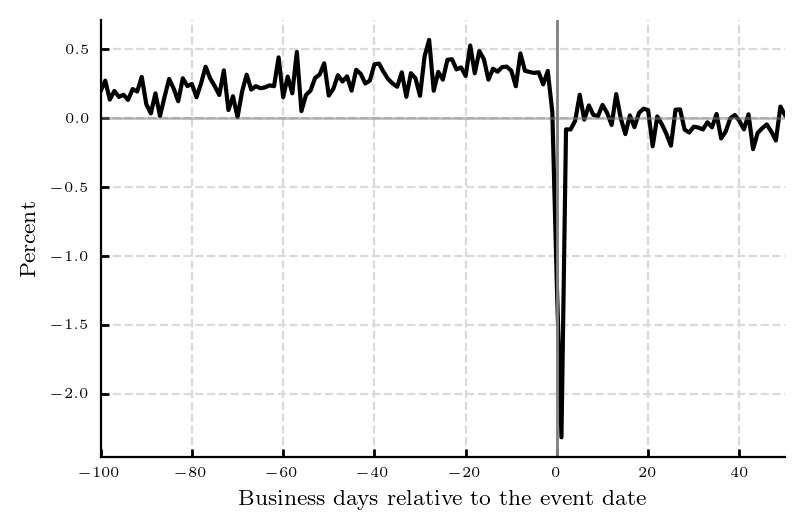

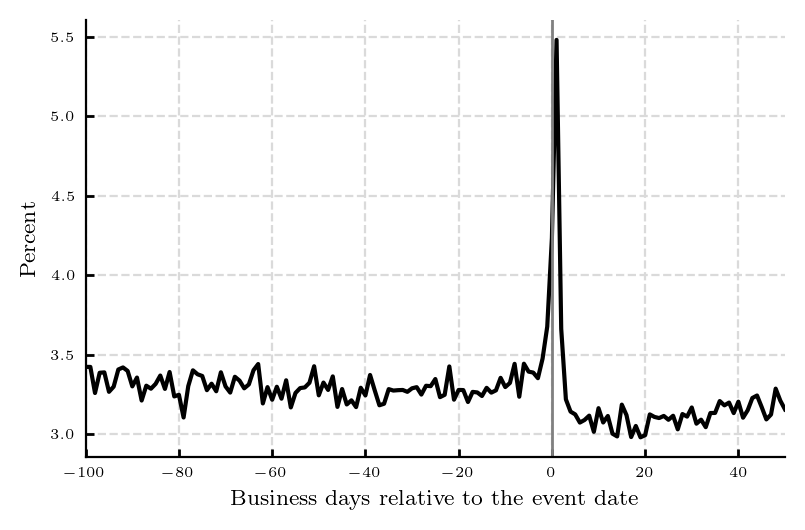

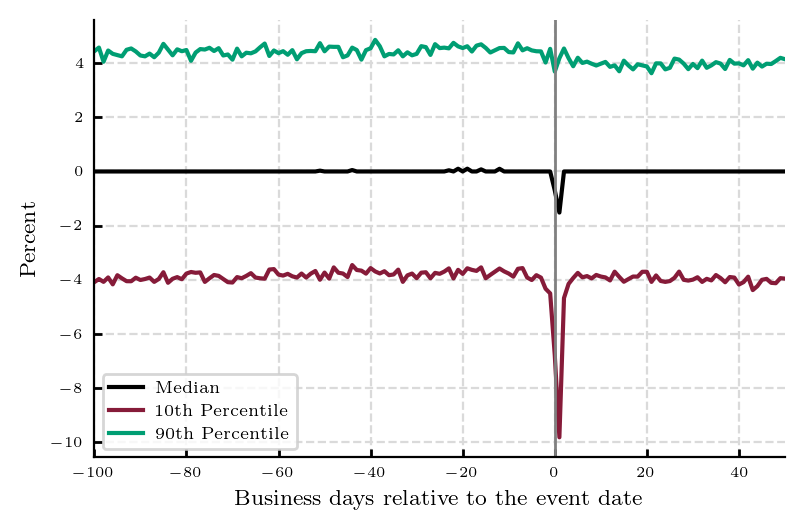

In [149]:
Fig, _ = EventPlot_Lines(StatPanel, {vv: LineDict[vv] for vv in ['mean',]}, Y_Benchmark=0, Flag_NoLegend=True)
Fig.savefig(OutputFolder + '/EventStudy_DailyReturn_Mean.eps', bbox_inches='tight', format='eps', dpi=1000)

Fig, _ = EventPlot_Lines(StatPanel, {vv: LineDict[vv] for vv in ['std_trunc',]}, Flag_NoLegend=True)
Fig.savefig(OutputFolder + '/EventStudy_DailyReturn_Std.eps', bbox_inches='tight', format='eps', dpi=1000)

Fig, _ = EventPlot_Lines(StatPanel, {vv: LineDict[vv] for vv in ['50%', '10%', '90%']})
Fig.savefig(OutputFolder + '/EventStudy_DailyReturn_Quantile.eps', bbox_inches='tight', format='eps', dpi=1000)

## Stock price relative to day -1


In [150]:
StatPanel = DS.groupby('EventDate')['AccRet'].apply(KeyRetStat).unstack(level=1).loc[-100:50,:]


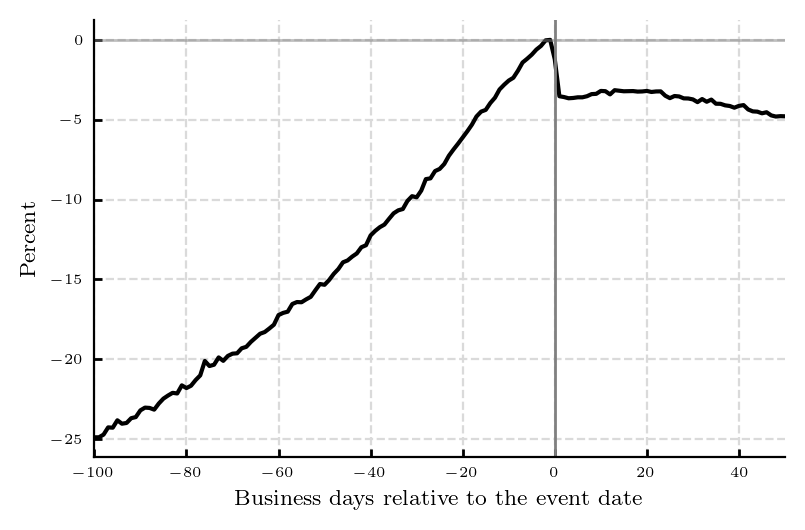

In [151]:
Fig, _ = EventPlot_Lines(StatPanel, {vv: LineDict[vv] for vv in ['mean',]}, Y_Benchmark=0, Flag_NoLegend=True)
Fig.savefig(OutputFolder + '/EventStudy_StockPrice_Mean.eps', bbox_inches='tight', format='eps', dpi=1000)

In [152]:
StatPanel.loc[-1:2, :]

,Frac_0,Frac_Pos,Frac_Neg,count,mean,std,min,1%,10%,25%,50%,75%,90%,99%,max,std_trunc
EventDate,,,,,,,,,,,,,,,,
-1.0,1.000000,0.000000,0.000000,3066.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,NaN
0.0,0.051192,0.375517,0.573291,3145.0,-0.012189,0.051599,-0.407968,-0.186736,-0.067955,-0.033571,-0.006993,0.013305,0.036930,0.120846,0.328979,0.042357
1.0,0.028683,0.280639,0.690678,3068.0,-0.035310,0.076981,-0.400478,-0.287759,-0.126441,-0.070275,-0.027399,0.005627,0.044039,0.146399,0.272867,0.067615
2.0,0.022085,0.305619,0.672296,3079.0,-0.035816,0.091858,-0.754600,-0.327375,-0.141079,-0.075555,-0.028468,0.012206,0.062400,0.180205,0.423572,0.079005
